In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import random
from imblearn.over_sampling import SMOTE, SVMSMOTE
from EDA_helper import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [35]:
def process_eda(stratified=False):
    """ 
    1. Read in energ, ratio

    2. format_df(ratio, ratings)

    2b. format_df(energ, ratings)

    merged = left_join(ratio, energ)

    3. join_numerical(merged, ratings)

    4. data_split to get holdout set (apply drop_na on this)

    will have quarterly granularity for test

    5. interpolate train data to fill in missing (expand quarterly to monthly) 
    """
    ratings = pd.read_excel("../datasets/ratings_all_energ_new.xlsx")
    ratio = pd.read_excel("../datasets/ratios_2_all_energ_new.xlsx")
    energ = pd.read_excel("../datasets/energ_specific_all_new.xlsx")
    # ratings = pd.read_excel("../datasets/ratings_2_06-17.xlsx")
    # ratio = pd.read_excel("../datasets/ratio_figs_2.xlsx")
    cols = ratio.columns
    ratio = ratio.drop(cols[0], axis=1)
    ratio = ratio.rename(columns = {'Public Date':'Data Date','EXCHANGE TICKER SYMBOL - HISTORICAL':'Ticker Symbol'})

    ratio1, ratings1 = format_df(ratio.copy(), ratings.copy(), 
                                 ['Trailing P/E to Growth (PEG) ratio','Dividend Yield', 
                                  'Interest/Average Total Debt', 'Free Cash Flow/Operating Cash Flow'])

    numer = list(ratio1.columns[4:-1])
    # yr = ['2006', '2007', '2008','2009','2010','2011','2012','2013']
    # X1,Y1,full1 = join_numerical(ratio1, ratings1, numerical=numer)
    cols = energ.columns
#     print(cols)
    # aa = cols[[0,1,2,3,4,5,6, 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
    aa = cols[[0,1,2,3,4,5,6, 10,11,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
    energ1 = energ.drop(
           aa, 
        axis=1)
    # energ1 = energ_.fillna(energ_.mean()) 
    # energ1, _ = format_df(energ.copy(), ratings.copy(), 
    #                             aa)
    energ1['Data Date'] = energ1['Data Date'].astype(str)
    energ1.shape
    features = pd.merge(ratio1, energ1,how='left',on=["Data Date", "Ticker Symbol"])
#     len(features["Ticker Symbol"].unique())
    lst3 = [value for value in ratio["Ticker Symbol"].unique() if value in energ["Ticker Symbol"].unique()]
    # ratio1["Ticker Symbol"].unique()
#     len(lst3)
#     print(len(ratio["Ticker Symbol"].unique()), len(energ["Ticker Symbol"].unique()), 
#           len(ratio1["Ticker Symbol"].unique()), len(energ1["Ticker Symbol"].unique()))

    first_col = features.pop("Ticker Symbol") 
    ff = len(features.columns)
    features.insert(ff, "Ticker Symbol", first_col)
    numer = list(features.columns[4:-1])

    X1,Y1,full1 = join_numerical(features, ratings1, numerical=numer)
    
    if stratified:
        full1 = full1.reset_index()
        comps = list(full1['Ticker Symbol'].unique())
        labout = []
        inout = []
        v_labout = []
        v_inout = []
        t_labout = []
        t_inout = []
        for c in comps:
            curr_in = full1.index[full1['Ticker Symbol'] == c]
            indXd = X1[curr_in,:]
            indYd = Y1[curr_in]
            if np.random.binomial(1, 0.9):
                if np.random.binomial(1, 0.8):
                    inout.append(indXd)
                    labout.append(indYd)
                else:
                    v_inout.append(indXd)
                    v_labout.append(indYd)
            else:
                t_inout.append(indXd)
                t_labout.append(indYd)
        X1,Y1, X_val_, Y_val, X_hold_,Y_hold = (np.vstack(inout),np.vstack(labout), np.vstack(v_inout),
                                               np.vstack(v_labout), np.vstack(t_inout), np.vstack(t_labout)) 
        ss = StandardScaler()
        scl_X = ss.fit_transform(X1)
        scl_X = np.nan_to_num(scl_X)
        enc_Y_, _ = encode(Y1, 'full') 

        X_val = ss.transform(X_val_)
        X_val = np.nan_to_num(X_val)
        Y_val, _ = encode(Y_val, 'full')
        
        X_hold = ss.transform(X_hold_)
        X_hold = np.nan_to_num(X_hold)

        Y_hold, _ = encode(Y_hold, 'full')
        minny = np.abs(np.min((np.min(enc_Y_), np.min(Y_val), np.min(Y_hold))))
        enc_Y = enc_Y_ + minny
        Y_val += minny
        Y_hold += minny


    else:
        X_val, Y_val = np.array([]),np.array([])
        X1, X_hold_,Y1, Y_hold = train_test_split(X1, Y1, test_size=0.2, random_state=100)
        ss = StandardScaler()
        scl_X = ss.fit_transform(X1)
        scl_X = np.nan_to_num(scl_X)
        enc_Y_, _ = encode(Y1, 'full') 

        X_hold = ss.transform(X_hold_)
        X_hold = np.nan_to_num(X_hold)

        Y_hold, _ = encode(Y_hold, 'full')
        minny = np.abs(np.min((np.min(enc_Y_), np.min(Y_hold))))
        enc_Y = enc_Y_ + minny
        Y_hold += minny
    print(scl_X.shape, X_val.shape, X_hold.shape)
    return scl_X, enc_Y, X_val, Y_val, X_hold, Y_hold, minny

In [36]:
X_train_, Y_train_, X_val,Y_val, X_test_, Y_test_, minny = process_eda()

Unique Companies in Ratings:  335
Unique Companies in Features:  253
changed
Intersection of Companies:  97
(6375, 26) (0,) (1594, 26)


## Distribution of Labels Before SMOTE

c:\users\rodri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


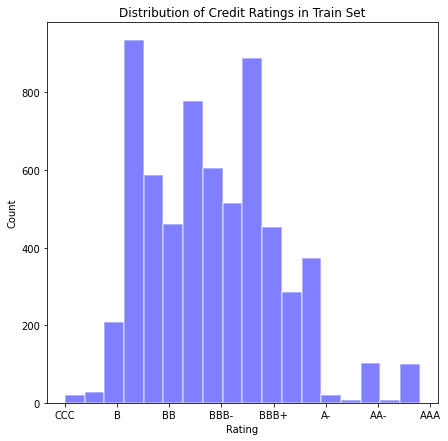

In [37]:
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(Y_train_, bins=len(np.unique(Y_train_)),facecolor='blue', linewidth=1.5,edgecolor='white', alpha=0.5)
ticks = [0, 'CCC',
#          'CCC+',  
#          'B-', 
         'B', 
#          'B+', 
#          'BB-', 
         'BB',
#          'BB+', 
         'BBB-', 
#          'BBB',
         'BBB+',  
         'A-', 
#          'A', 
#          'A+', 
         'AA-', 
#          'AA', 
#          'AA+',  
         'AAA']

ax.set_xticklabels(ticks)
ax.set_title('Distribution of Credit Ratings in Train Set')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.show()
# ticks

## Distribution of Labels After SMOTE

The SMOTE sampling strategy can be altered in the EDA_helper.py file. The current strategy displayed in this notebook is less extreme compared to the paper - for purposes of exaggerating the effects of SMOTE for the visualization.

In [38]:
X_train, Y_train, _, _,X_test, Y_test = data_split(X_train_, Y_train_, split=[0.8, 0.0], smote=True, seed = 200, neigh=5)

c:\users\rodri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


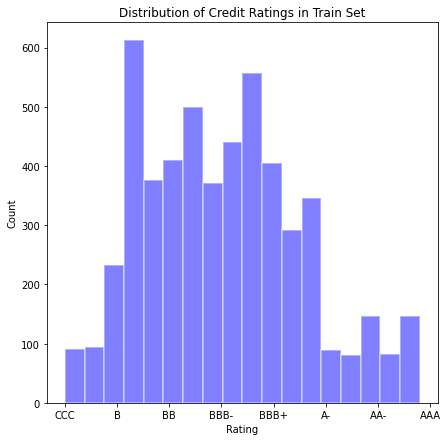

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(Y_train, bins=len(np.unique(Y_train)),facecolor='blue', linewidth=1.5,edgecolor='white', alpha=0.5)
ticks = [0, 'CCC',
#          'CCC+',  
#          'B-', 
         'B', 
#          'B+', 
#          'BB-', 
         'BB',
#          'BB+', 
         'BBB-', 
#          'BBB',
         'BBB+',  
         'A-', 
#          'A', 
#          'A+', 
         'AA-', 
#          'AA', 
#          'AA+',  
         'AAA']

ax.set_xticklabels(ticks)
ax.set_title('Distribution of Credit Ratings in Train Set')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.show()
# ticks

In [40]:
pca = PCA()
principalComponents = pca.fit_transform(X_train)

In [41]:
dec,_ = decode((Y_train - minny), 'full')

<class 'numpy.ndarray'>


## Figure for Full Label Set PCA

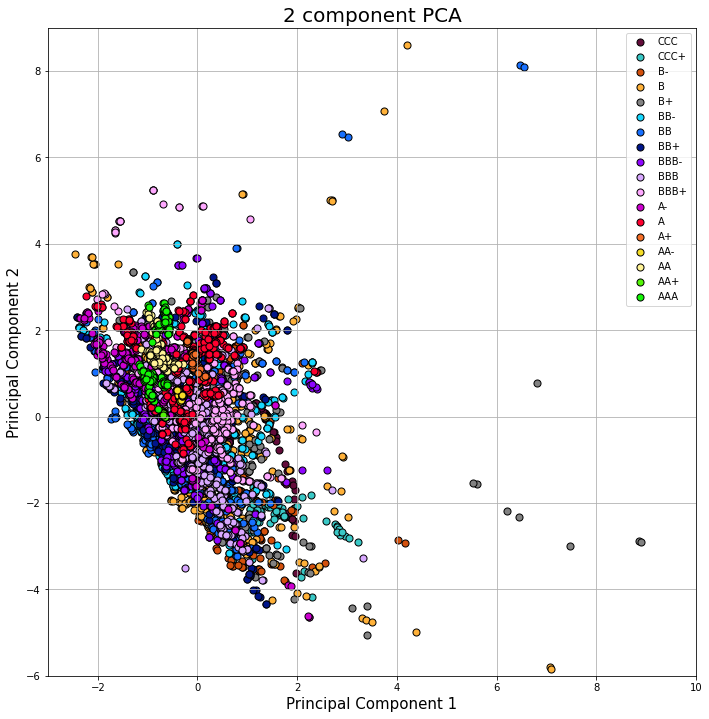

In [42]:
principalDf = pd.DataFrame(data = principalComponents[:, 0:2]
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(dec, columns=['rating'])], axis = 1)

plt.figure(1, figsize=(10,10))
bottom = 0.05
height = 0.9
width = 0.9  # * 4 = 0.6 - minus the 0.1 padding 0.3 left for space
left1, left2 = 0.05, 1.05
rectangle1 = [left1, bottom, width, height]
rectangle2 = [left2, bottom, width, height]

ax = plt.axes(rectangle1)
# ax1 = plt.axes(rectangle2)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['CCC','CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
# targets = [-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8]
colors = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#828282', '#17d8ff', '#1770ff',
         '#00158a', '#8f05ff', '#d8a8ff', '#fea8ff', '#cc00cf', '#ff002f', '#f56f27',
         '#f5dd27', '#fff396', '#53f507', '#13f507']

for target, color in zip(targets,colors):
#     print(target, color)
    indicesToKeep = finalDf['rating'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
              , edgecolors='black')
# ax1 = fig.add_subplot(1,2,1)
ax.set_xlim(-3, 10)
ax.set_ylim(-6,9)
# ax1.set_title('2')
# for target, color in zip(targets[11:14],colors[11:14]):
# #     print(target, color)
#     indicesToKeep = finalDf['rating'] == target
#     ax1.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 50
#               , edgecolors='black')
# ax1.set_xlim(-3, 9)
# ax1.set_ylim(-2,5)

# ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c = Y_emb)
ax.legend(targets)
# ax1.legend(targets[11:14])
# ax1.grid()
ax.grid()

## Produce Figure for Full Label Set CCA

Training CCA, kernel = None, regularization = 0.0000, 2 components
Canonical Correlation Per Component Pair: [0.51962219 0.31372164]
% Shared Variance: [0.27000722 0.09842127]
weghts


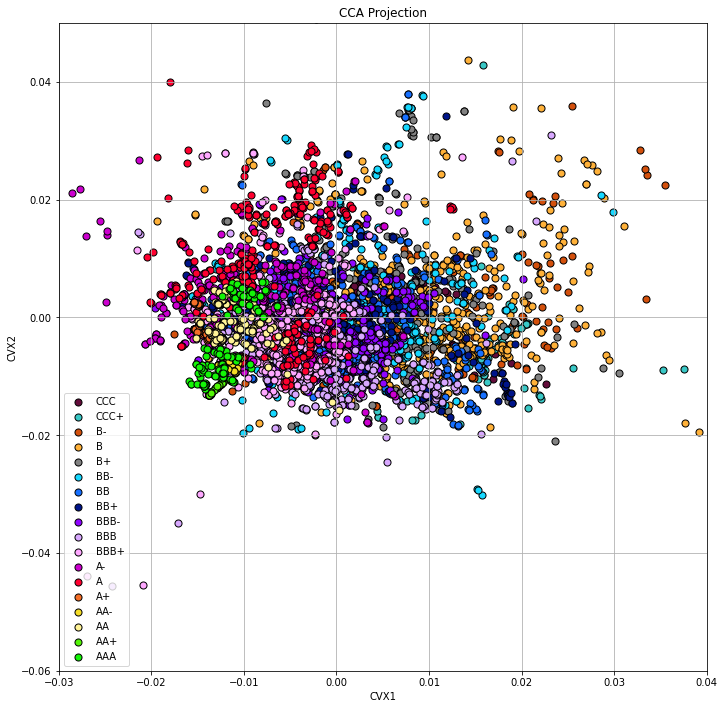

In [43]:
import rcca

dum_Y = pd.get_dummies(pd.Series(Y_train))


nComponents = 2 # min(p,q) components
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents,)
# train on data
cca.train([X_train, dum_Y])
print('Canonical Correlation Per Component Pair:',cca.cancorrs)
print('% Shared Variance:',cca.cancorrs**2)
print('weghts')
w1 = cca.ws[0][:,0]
w2 = cca.ws[0][:,1]
cca_df = pd.DataFrame(np.vstack((cca.comps[0][:,0], cca.comps[0][:,1])).T, columns=['CVX1', 'CVX2'])
# cca_df['Y'] = pd.Series(Y_emb).apply(lambda x: str(int(x)))
cca_df['Y'] = pd.Series(dec)
# .apply(lambda x: str(int(x)))
cca_df['yr'] = full1['year']
#################################################################################################

plt.figure(1, figsize=(10,10))
bottom = 0.05
height = 0.9
width = 0.9  # * 4 = 0.6 - minus the 0.1 padding 0.3 left for space
left1, left2 = 0.05, 1.05
rectangle1 = [left1, bottom, width, height]
# rectangle2 = [left2, bottom, width, height]

ax2 = plt.axes(rectangle1)
# ax3 = plt.axes(rectangle2)
# yrs1 = ['2007', '2008', '2009', '2010']
# yrs2 = ['2011', '2012', '2013', '2014', '2015', '2016']
colors = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#828282', '#17d8ff', '#1770ff',
         '#00158a', '#8f05ff', '#d8a8ff', '#fea8ff', '#cc00cf', '#ff002f', '#f56f27',
         '#f5dd27', '#fff396', '#53f507', '#13f507']
targets = ['CCC','CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
for target, color in zip(targets,colors):
#     print(target, color)
    indicesToKeep = (cca_df['Y'] == target)
    ax2.scatter(cca_df.loc[indicesToKeep, 'CVX1']
               , cca_df.loc[indicesToKeep, 'CVX2']
               , c = color
               , s = 50
              , edgecolors='black')


    # plt.scatter(cca_df['CVX1'],cca_df['CVX2'], c=cca_df['Y'])

### MAKES SURE ALL ELEMENTS FIT IN BOTH PLOTS AND HAVE SAME SIZE 
# x_l = min(ax2.get_xlim()[0], ax3.get_xlim()[0])
# x_r = max(ax2.get_xlim()[1], ax3.get_xlim()[1])

# y_l = min(ax2.get_ylim()[0], ax3.get_ylim()[0])
# y_r = max(ax2.get_ylim()[1], ax3.get_ylim()[1])

ax2.set_xlim(-0.03, 0.04)
# ax3.set_xlim(x_l, x_r)
ax2.set_ylim(-0.06, 0.05)
# ax3.set_ylim(y_l, y_r)

ax2.legend(targets)
# ax3.legend(subset)
ax2.set_title("CCA Projection")
ax2.set_xlabel('CVX1')
ax2.set_ylabel('CVX2')
ax2.grid()
# ax3.set_title("CCA Projection for :" + str(yrs2))
plt.show()
# cca.comps[1][:,0]